# COVID-19 Vaccination Project:  Data Cleaning 

In [1]:
# Necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)
#pd.options.mode.chained_assignment = None  # default='warn'

## Inspecting & Cleaning CDC vaccine data

>- %_vax represents % of adults who have recieved at least 1 dose of COVID-19 vaccine

In [2]:
def import_csv_data(path):
    return pd.read_csv(path)

In [3]:
# importing CDC data from webscraping notebook (via csv)

PATH = 'cdc_data.csv'
cdc_data = import_csv_data(PATH)
cdc_data.head()

,state,county,fips,%_vax,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus
0,Alabama,Autauga County,1001,43.6,93.99,2.59,7.1,15.4,15.97
1,Alabama,Baldwin County,1003,51.9,140.41,2.61,10.2,10.6,20.98
2,Alabama,Barbour County,1005,43.9,27.89,2.49,11.2,28.9,19.69
3,Alabama,Bibb County,1007,37.0,35.98,2.99,7.9,14.0,16.67
4,Alabama,Blount County,1009,31.5,89.68,2.77,11.0,14.4,18.70


In [4]:
cdc_data.shape

(3219, 9)

### Inspect & clean list of states 
>- Dataframe includes all 50 states + Puerto Rico

In [5]:
def check_state_column(df, state_column='state'):
    
    '''Prints info about the state column, including the number of states, 
    the name of each state, and the number of counties per state'''
    
    print(f'Number of states: {df.groupby(state_column).size().shape[0]} \n')
    print(f'Counties per state: \n{df.groupby(state_column).size()}')

In [6]:
check_state_column(df=cdc_data)

Number of states: 51 

Counties per state: 
state
Alabama            67
Alaska             29
Arizona            15
Arkansas           75
California         58
Colorado           64
Connecticut         8
Delaware            3
Florida            67
Georgia           159
Hawaii              5
Idaho              44
Illinois          102
Indiana            92
Iowa               99
Kansas            105
Kentucky          120
Louisiana          64
Maine              16
Maryland           24
Massachusetts      14
Michigan           83
Minnesota          87
Mississippi        82
Missouri          115
Montana            56
Nebraska           93
Nevada             17
New Hampshire      10
New Jersey         21
New Mexico         33
New York           62
North Carolina    100
North Dakota       53
Ohio               88
Oklahoma           77
Oregon             36
Pennsylvania       67
Puerto Rico        78
Rhode Island        5
South Carolina     46
South Dakota       66
Tennessee          95
Texa

In [7]:
# dropping Puerto Rico's 78 counties since it isn't a state

cdc_data = cdc_data[cdc_data['state'] != 'Puerto Rico']
cdc_data.shape

(3141, 9)

### Null values

- Lots of nulls in %_vax column and 1 in %_poverty_rate

In [8]:
def check_for_nulls(df):
    '''Returns number of nulls in each column of a dataframe
    '''
    return df.isnull().sum()

In [9]:
check_for_nulls(df=cdc_data)

state               0
county              0
fips                0
%_vax             580
pop_density         0
household_size      0
%_uninsured         0
%_poverty_rate      1
%_age_65_plus       0
dtype: int64

- Some states are missing a portion of their counties
- Others (including Texas, Nebraska, Hawaii) are missing data for all counties

In [10]:
# number of nulls in % vax column per state
cdc_data[cdc_data['%_vax'].isnull()].groupby('state').size()

state
Alaska              1
California          8
Colorado           57
Georgia            27
Hawaii              5
Indiana             1
Kentucky            1
Michigan            8
Minnesota           2
Montana             1
Nebraska           90
New Mexico         32
Ohio               26
Oklahoma            1
Pennsylvania        2
Rhode Island        4
South Carolina      1
South Dakota       52
Texas             253
Utah                1
Virginia            7
dtype: int64

#### Handling nulls in % vaccinated column

580 nulls in the % vaccinated column, out of 3141 total rows
- For states missing data in 100% of counties, imputation based on another state would not lead to plausible values
- In states with data missing from <100% of counties, we could impute with mean value for state....however, within a state, it's quite likely that the counties NOT reporting to CDC are different from those that ARE reporting
    - For example, California's 8 counties with missing values are also it's smallest, most rural counties - and fundamentally different from the average county in the state  
- **Since imputation would likely significantly distort the data, will drop counties with missing values**

#### Handling null in %_poverty_rate column
- Looks like the 1 null in %_poverty is also null in %_vax, so it will be dropped regardless

In [11]:
cdc_data[cdc_data['%_poverty_rate'].isnull()]

,state,county,fips,%_vax,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus
1815,New Mexico,Rio Arriba County,35039,NaN,6.64,3.12,10.6,NaN,20.08


In [12]:
# dropping all nulls

cdc_data = cdc_data.dropna()
cdc_data.shape

(2561, 9)

### Converting % vax to % unvacc

> - Currently have '%_vax' (i.e. '% adults with at least 1 shot'), but target is % UNvaccinated
> - % UNvaccinated = 100% - % adults with at least 1 shot   

In [13]:
def vax_to_unvax(df):
    '''Converting % vaccinated column to % unvaccinated'''
    
    df['%_unvax'] = df['%_vax'].apply(lambda x: (100 - x))
    df = df.drop('%_vax', axis=1)
    return df

In [14]:
cdc_data = vax_to_unvax(df=cdc_data)

## Inspecting & Cleaning 2020 presidential election dataset

In [15]:
# Data obtained from GitHub user @tonmcg, was originally scraped from the New York Times

PATH = '2020_US_County_Level_Presidential_Results.csv'
election_2020 = import_csv_data(PATH)

In [16]:
election_2020.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [17]:
election_2020.shape

(3152, 10)

### Inspect & clean list of states 
> Dataframe contains all 50 states + DC

In [18]:
check_state_column(df=election_2020, state_column='state_name')

Number of states: 51 

Counties per state: 
state_name
Alabama                  67
Alaska                   40
Arizona                  15
Arkansas                 75
California               58
Colorado                 64
Connecticut               8
Delaware                  3
District of Columbia      1
Florida                  67
Georgia                 159
Hawaii                    4
Idaho                    44
Illinois                102
Indiana                  92
Iowa                     99
Kansas                  105
Kentucky                120
Louisiana                64
Maine                    16
Maryland                 24
Massachusetts            14
Michigan                 83
Minnesota                87
Mississippi              82
Missouri                115
Montana                  56
Nebraska                 93
Nevada                   17
New Hampshire            10
New Jersey               21
New Mexico               33
New York                 62
North Carolina       

In [19]:
# dropping DC since it's not a state

election_2020 = election_2020[election_2020['state_name'] != 'District of Columbia']
election_2020.shape

(3151, 10)

### Nulls 
> No nulls!

In [20]:
check_for_nulls(df=election_2020)

state_name        0
county_fips       0
county_name       0
votes_gop         0
votes_dem         0
total_votes       0
diff              0
per_gop           0
per_dem           0
per_point_diff    0
dtype: int64

### Cleaning election dataset

**Outcomes of 2020 presidential election on the county level**   

**Numerical columns in this dataset:**
  
**Votes GOP**: # of votes for GOP candidate (Trump)  
**Votes Dem**: # of votes for Dem candidate (Biden)  
**Total Votes**: total # of votes   
**Vote Diff** = difference between # of GOP votes and # of Dem votes (negative values in blue counties, positive values in red counties)
          
**%GOP** = % of vote going to GOP candidate (Trump)  
**%Dem** = % of vote going to Dem candidate (Biden)  
**%Diff** = difference between %GOP and %Dem candidates (the "split")  (negative in blue counties, positive in red counties)

**At the end of the day, the only column we need is the %Diff, because it tells us about all the rest!**   
**--> So will drop the rest of the numerical columns**

In [21]:
# selecting only the useful columns and renaming them

election_2020 = election_2020.loc[:, ['state_name', 'county_fips', 'county_name', 'per_point_diff']]
election_2020.columns=(['state_name', 'fips', 'county_name', '%_diff'])

In [22]:
# converting decimals to percentages, rounding to 2 decimal points

election_2020['%_diff'] = (election_2020['%_diff'] * 100).round(2)
election_2020.head()

,state_name,fips,county_name,%_diff
0,Alabama,1001,Autauga County,44.42
1,Alabama,1003,Baldwin County,53.76
2,Alabama,1005,Barbour County,7.66
3,Alabama,1007,Bibb County,57.73
4,Alabama,1009,Blount County,80.00


### Putting election results into bins

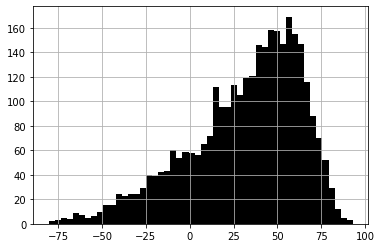

In [23]:
# visualizing % diff: red counties are (+) and blue are (-)
# vast majority of counties are red!

election_2020['%_diff'].hist(bins=50, color='black');

In [24]:
def make_vote_split_column(numerical_column=election_2020['%_diff'],
                           bins=[-100, -30, -10, 10, 30, 100]):
    
    '''Putting %_diff (a numerical column) into bins to create a categorical 
    column (vote _split)'''
    
    vote_split = pd.cut(numerical_column, bins)
    election_2020['vote_split'] = vote_split
    print(f'Number of counties per bin:\n\n{vote_split.value_counts()}')

In [25]:
make_vote_split_column()

Number of counties per bin:

(30, 100]      1857
(10, 30]        568
(-10, 10]       336
(-30, -10]      223
(-100, -30]     167
Name: %_diff, dtype: int64


## Inspecting & Cleaning 2020 demographics dataset

In [26]:
# Importing demographics data from OpenIntro

PATH = "OpenIntro_final.csv"
demographics = import_csv_data(PATH)
demographics.head()

,fips,state,name,asian_2019,black_2019,hispanic_2019,native_2019,pac_isl_2019,white_not_hispanic_2019,household_has_computer_2019,household_has_smartphone_2019,hs_grad_2019,bachelors_2019,median_household_income_2019
0,1001,Alabama,Autauga County,1.0,19.0,2.8,0.3,0.0,74.6,73.0,78.4,88.5,26.6,58731
1,1003,Alabama,Baldwin County,0.9,9.3,4.6,0.8,0.0,83.1,76.3,81.7,90.8,31.9,58320
2,1005,Alabama,Barbour County,0.5,47.6,4.4,0.3,0.0,45.8,51.9,64.2,73.2,11.6,32525
3,1007,Alabama,Bibb County,0.1,22.3,2.6,0.1,0.0,74.5,54.7,66.6,79.1,10.4,47542
4,1009,Alabama,Blount County,0.4,1.6,9.3,0.1,0.0,86.9,63.5,70.1,80.5,13.1,49358


In [27]:
demographics.shape

(3142, 14)

### Inspect & clean list of states 
> Dataframe contains all 50 states + DC

In [28]:
check_state_column(df=demographics)

Number of states: 51 

Counties per state: 
state
Alabama                  67
Alaska                   29
Arizona                  15
Arkansas                 75
California               58
Colorado                 64
Connecticut               8
Delaware                  3
District of Columbia      1
Florida                  67
Georgia                 159
Hawaii                    5
Idaho                    44
Illinois                102
Indiana                  92
Iowa                     99
Kansas                  105
Kentucky                120
Louisiana                64
Maine                    16
Maryland                 24
Massachusetts            14
Michigan                 83
Minnesota                87
Mississippi              82
Missouri                115
Montana                  56
Nebraska                 93
Nevada                   17
New Hampshire            10
New Jersey               21
New Mexico               33
New York                 62
North Carolina          10

In [29]:
# dropping DC since it isn't a state

demographics = demographics[demographics['state'] != 'District of Columbia']
demographics.shape

(3141, 14)

### Nulls 
> No nulls!

In [30]:
check_for_nulls(df=demographics)

fips                             0
state                            0
name                             0
asian_2019                       0
black_2019                       0
hispanic_2019                    0
native_2019                      0
pac_isl_2019                     0
white_not_hispanic_2019          0
household_has_computer_2019      0
household_has_smartphone_2019    0
hs_grad_2019                     0
bachelors_2019                   0
median_household_income_2019     0
dtype: int64

In [31]:
# renaming columns

demographics.columns=(['fips', 'state_name', 'county_name', '%_asian',
                       '%_black', '%_hispanic', '%_native', '%_pac_isl', 
                      '%_white', '%_computer', '%_phone', '%_hs_grad',
                      '%_bachelors', 'median_house_income'])
demographics.head()

,fips,state_name,county_name,%_asian,%_black,%_hispanic,%_native,%_pac_isl,%_white,%_computer,%_phone,%_hs_grad,%_bachelors,median_house_income
0,1001,Alabama,Autauga County,1.0,19.0,2.8,0.3,0.0,74.6,73.0,78.4,88.5,26.6,58731
1,1003,Alabama,Baldwin County,0.9,9.3,4.6,0.8,0.0,83.1,76.3,81.7,90.8,31.9,58320
2,1005,Alabama,Barbour County,0.5,47.6,4.4,0.3,0.0,45.8,51.9,64.2,73.2,11.6,32525
3,1007,Alabama,Bibb County,0.1,22.3,2.6,0.1,0.0,74.5,54.7,66.6,79.1,10.4,47542
4,1009,Alabama,Blount County,0.4,1.6,9.3,0.1,0.0,86.9,63.5,70.1,80.5,13.1,49358


## Joining the 3 datasets 

In [32]:
def join_two_datasets(df_left, df_right, how='left', on='fips'):
    
    '''Left join of two datasets on the county FIPS (a number unique to each county)
    '''
    
    return df_left.merge(df_right, how=how, on=on)

### Joining CDC and election datasets

In [33]:
vax_data = join_two_datasets(df_left=cdc_data, df_right=election_2020)
vax_data.head()

,state,county,fips,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_unvax,state_name,county_name,%_diff,vote_split
0,Alabama,Autauga County,1001,93.99,2.59,7.1,15.4,15.97,56.4,Alabama,Autauga County,44.42,"(30, 100]"
1,Alabama,Baldwin County,1003,140.41,2.61,10.2,10.6,20.98,48.1,Alabama,Baldwin County,53.76,"(30, 100]"
2,Alabama,Barbour County,1005,27.89,2.49,11.2,28.9,19.69,56.1,Alabama,Barbour County,7.66,"(-10, 10]"
3,Alabama,Bibb County,1007,35.98,2.99,7.9,14.0,16.67,63.0,Alabama,Bibb County,57.73,"(30, 100]"
4,Alabama,Blount County,1009,89.68,2.77,11.0,14.4,18.70,68.5,Alabama,Blount County,80.00,"(30, 100]"


### Cleaning joined dataset

> **For each of Alaska's 28 counties, the cdc data fail to match up with elections data**  
>- Looks like Alaska administers it's elections by legislative district, NOT county -  so it is not possible to reconcile election data with county-level vaccine data
>- Considered imputing using state-level election data, which would mean turning all counties red. However, doing so would likely significantly distort the data because there are some deeply blue areas of the state 
>- Since election data is important to this project, will drop Alaska from the dataset

In [34]:
check_for_nulls(df=vax_data)

state              0
county             0
fips               0
pop_density        0
household_size     0
%_uninsured        0
%_poverty_rate     0
%_age_65_plus      0
%_unvax            0
state_name        28
county_name       28
%_diff            28
vote_split        28
dtype: int64

In [35]:
# all the nulls are from Alaska

vax_data[vax_data['state'] == 'Alaska']

,state,county,fips,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_unvax,state_name,county_name,%_diff,vote_split
67,Alaska,Aleutians East Borough,2013,0.48,2.60,45.6,15.4,10.52,24.7,NaN,NaN,NaN,NaN
68,Alaska,Aleutians West CA,2016,1.28,3.72,18.8,8.5,7.44,33.4,NaN,NaN,NaN,NaN
69,Alaska,Anchorage Muny,2020,168.74,2.71,12.2,9.2,11.72,31.5,NaN,NaN,NaN,NaN
70,Alaska,Bethel CA,2050,0.45,3.77,20.7,27.8,7.88,22.3,NaN,NaN,NaN,NaN
71,Alaska,Bristol Bay Borough,2060,1.73,2.45,19.8,5.8,16.27,0.1,NaN,NaN,NaN,NaN
72,Alaska,Denali Borough,2068,0.17,2.29,19.2,16.9,11.35,43.2,NaN,NaN,NaN,NaN
73,Alaska,Dillingham CA,2070,0.27,3.25,22.4,17.2,10.05,43.3,NaN,NaN,NaN,NaN
74,Alaska,Fairbanks North Star Borough,2090,13.21,2.61,10.0,8.1,11.18,42.5,NaN,NaN,NaN,NaN
75,Alaska,Haines Borough,2100,1.08,2.41,15.5,9.0,21.66,28.4,NaN,NaN,NaN,NaN
76,Alaska,Hoonah-Angoon CA,2105,0.33,2.47,25.1,9.7,24.02,25.9,NaN,NaN,NaN,NaN


In [36]:
# dropping Alaska' 28 counties 

vax_data = vax_data[vax_data['state'] != 'Alaska']
vax_data.shape

(2533, 13)

In [37]:
# removing extraneous columns

vax_data = vax_data.drop(columns=['state_name', 'county_name'])
vax_data.head()

,state,county,fips,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_unvax,%_diff,vote_split
0,Alabama,Autauga County,1001,93.99,2.59,7.1,15.4,15.97,56.4,44.42,"(30, 100]"
1,Alabama,Baldwin County,1003,140.41,2.61,10.2,10.6,20.98,48.1,53.76,"(30, 100]"
2,Alabama,Barbour County,1005,27.89,2.49,11.2,28.9,19.69,56.1,7.66,"(-10, 10]"
3,Alabama,Bibb County,1007,35.98,2.99,7.9,14.0,16.67,63.0,57.73,"(30, 100]"
4,Alabama,Blount County,1009,89.68,2.77,11.0,14.4,18.70,68.5,80.00,"(30, 100]"


### Joining with demographics dataset

In [38]:
vax_data = join_two_datasets(df_left=vax_data, df_right=demographics)
vax_data.head()

,state,county,fips,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_unvax,%_diff,vote_split,state_name,county_name,%_asian,%_black,%_hispanic,%_native,%_pac_isl,%_white,%_computer,%_phone,%_hs_grad,%_bachelors,median_house_income
0,Alabama,Autauga County,1001,93.99,2.59,7.1,15.4,15.97,56.4,44.42,"(30, 100]",Alabama,Autauga County,1.0,19.0,2.8,0.3,0.0,74.6,73.0,78.4,88.5,26.6,58731
1,Alabama,Baldwin County,1003,140.41,2.61,10.2,10.6,20.98,48.1,53.76,"(30, 100]",Alabama,Baldwin County,0.9,9.3,4.6,0.8,0.0,83.1,76.3,81.7,90.8,31.9,58320
2,Alabama,Barbour County,1005,27.89,2.49,11.2,28.9,19.69,56.1,7.66,"(-10, 10]",Alabama,Barbour County,0.5,47.6,4.4,0.3,0.0,45.8,51.9,64.2,73.2,11.6,32525
3,Alabama,Bibb County,1007,35.98,2.99,7.9,14.0,16.67,63.0,57.73,"(30, 100]",Alabama,Bibb County,0.1,22.3,2.6,0.1,0.0,74.5,54.7,66.6,79.1,10.4,47542
4,Alabama,Blount County,1009,89.68,2.77,11.0,14.4,18.70,68.5,80.00,"(30, 100]",Alabama,Blount County,0.4,1.6,9.3,0.1,0.0,86.9,63.5,70.1,80.5,13.1,49358


### Cleaning joined dataset
> No nulls!

In [39]:
# no nulls

check_for_nulls(df=vax_data)

state                  0
county                 0
fips                   0
pop_density            0
household_size         0
%_uninsured            0
%_poverty_rate         0
%_age_65_plus          0
%_unvax                0
%_diff                 0
vote_split             0
state_name             0
county_name            0
%_asian                0
%_black                0
%_hispanic             0
%_native               0
%_pac_isl              0
%_white                0
%_computer             0
%_phone                0
%_hs_grad              0
%_bachelors            0
median_house_income    0
dtype: int64

In [40]:
# removing extraneous columns

vax_data = vax_data.drop(columns=['fips', 'state_name', 'county_name'])

In [41]:
def move_columns_left(columns, df=vax_data, loc_index=2):
    
    '''Moves select columns left, closer to the index
    '''
    for column in columns:
        col_values = df.pop(column)
        df.insert(loc=loc_index, column=column, value=col_values)

In [42]:
# moving important columns

columns=['%_diff', '%_unvax', 'vote_split']
move_columns_left(columns)

In [43]:
vax_data.head()

,state,county,vote_split,%_unvax,%_diff,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_asian,%_black,%_hispanic,%_native,%_pac_isl,%_white,%_computer,%_phone,%_hs_grad,%_bachelors,median_house_income
0,Alabama,Autauga County,"(30, 100]",56.4,44.42,93.99,2.59,7.1,15.4,15.97,1.0,19.0,2.8,0.3,0.0,74.6,73.0,78.4,88.5,26.6,58731
1,Alabama,Baldwin County,"(30, 100]",48.1,53.76,140.41,2.61,10.2,10.6,20.98,0.9,9.3,4.6,0.8,0.0,83.1,76.3,81.7,90.8,31.9,58320
2,Alabama,Barbour County,"(-10, 10]",56.1,7.66,27.89,2.49,11.2,28.9,19.69,0.5,47.6,4.4,0.3,0.0,45.8,51.9,64.2,73.2,11.6,32525
3,Alabama,Bibb County,"(30, 100]",63.0,57.73,35.98,2.99,7.9,14.0,16.67,0.1,22.3,2.6,0.1,0.0,74.5,54.7,66.6,79.1,10.4,47542
4,Alabama,Blount County,"(30, 100]",68.5,80.00,89.68,2.77,11.0,14.4,18.70,0.4,1.6,9.3,0.1,0.0,86.9,63.5,70.1,80.5,13.1,49358


In [44]:
# total of 2533 counties, 17 features

vax_data.shape

(2533, 21)

In [45]:
vax_data.to_csv('vax_data.csv', index=False)